## Calculate the IDDs for courses
Here we are going to reproduce the calculations that INEP has done to transform the ENADE scores of individual last-year studentes into a value-added measure, the so-called "IDD" of the course (indicator for deviation from the expected value). 

Briefly, the IDD is calculated as follows. First, a model is estimated for the ENADE score as a function of the ENEM score of the student when they entered:

$$ \text{ENADE}_{ic} = \beta_{0c} + \beta \text{ENEM}_i + \epsilon_i $$
$$\beta_{0c} = N(\beta_{00},\sigma^{2}_{\beta}) $$

As you can see, this is a multi-level model with varying intercepts for courses. Now, the correct way to use this model is to identify $\beta_{0c}$ with the added value, the IDD, of a course. We show this visually below. 

However, according to the technical notes of INEP the IDD for one course is calculated using the the sum of the residuals for each N students: $\text{IDD}_{c} = \sum_i \epsilon_i / N$. This does not make any sense. 

Let's generate a figure with simulated data to show why the intercepts estimated from the multilevel model are the correct value added of a course, and not the way INEP calculates the IDD. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('paper',font_scale=1.7)

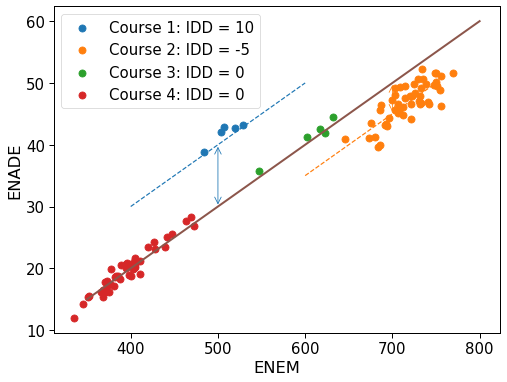

In [3]:
N1,N2,N3,N4 = 5,50,50,5 # alunos em cada grupo
intercept, beta = -20, 0.1 # enade = -20 + 0.1*enem (aprox os coeficientes reais)
idd1,idd2 = 10, -5 # "valor agregado" do curso 1 e 2
enem1 = 500 + 30*np.random.randn(N1)
enem2 = 700 + 30*np.random.randn(N2)
enem3 = 400 + 30*np.random.randn(N3)
enem4 = 600 + 30*np.random.randn(N4)
enem = np.array([350,800])
enem_1 = np.array([400,600])
enem_2 = np.array([600,750])
enem_3 = np.array([300,500])
enem_4 = np.array([500,850])

enade_m = enem*beta + intercept
enade_1 = enem_1*beta + intercept + idd1
enade_2 = enem_2*beta + intercept + idd2
enade1 = idd1 + enem1*beta + intercept + 2*np.random.randn(N1)
enade2 = idd2 + enem2*beta + intercept + 2*np.random.randn(N2)
enade3 = enem3*beta + intercept + 1*np.random.randn(N3)
enade4 = enem4*beta + intercept + 1*np.random.randn(N4)

fig = plt.figure(figsize=(8,6))
coursestring = 'Course'
plt.plot(enem,enade_m,color="C5",linewidth=2,label="")
plt.scatter(enem1,enade1,s=50,label=coursestring+" 1: IDD = %i" % idd1)
plt.scatter(enem2,enade2,s=50,label=coursestring+" 2: IDD = %i" % idd2)
plt.scatter(enem4,enade4,s=50,label=coursestring+" 3: IDD = 0")
plt.scatter(enem3,enade3,s=50,label=coursestring+" 4: IDD = 0")

plt.plot(enem_1,enade_1,'--',color='C0')
plt.plot(enem_2,enade_2,'--',color='C1')
ax = plt.gca()
scorestring = "score"
ax.set_ylabel("ENADE")
ax.set_xlabel("ENEM")
#ax.set_title("Cálculo do IDD (valor $agregado$ de cursos, dados simulados)")
ax.annotate("",xy=(500,intercept+500*beta),xytext=(500,intercept+idd1+500*beta),arrowprops=dict(arrowstyle='<->',color='C0'))
ax.annotate("",xy=(700,intercept+700*beta),xytext=(700,intercept+idd2+700*beta),arrowprops=dict(arrowstyle='<->',color='C1'))
ax.legend()

for dpi in [50,300]:
     fn = 'figs/idd-simulated-{}.png'.format(dpi)
     plt.savefig(fn,dpi=dpi)

Let's fit the above data with Lmer

In [4]:
data = pd.concat([pd.DataFrame({'enem':x,'enade':y,'curso':c}) for x,y,c in [(enem1,enade1,1),(enem2,enade2,2),(enem3,enade3,3),(enem4,enade4,4)] ])
import numpy as np
from pymer4.models import Lmer
import scipy.stats as stats
model = Lmer('enade ~ enem + (1|curso)',data=data)
model.fit()

Formula: enade~enem+(1|curso)

Family: gaussian	 Inference: parametric

Number of observations: 110	 Groups: {'curso': 4.0}

Log-likelihood: -213.320 	 AIC: 426.640

Random effects:

                 Name     Var    Std
curso     (Intercept)  46.360  6.809
Residual                2.243  1.498

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-19.345,-28.067,-10.623,4.450,8.041,-4.347,0.002,**
enem,0.102,0.092,0.112,0.005,107.926,19.897,0.000,***


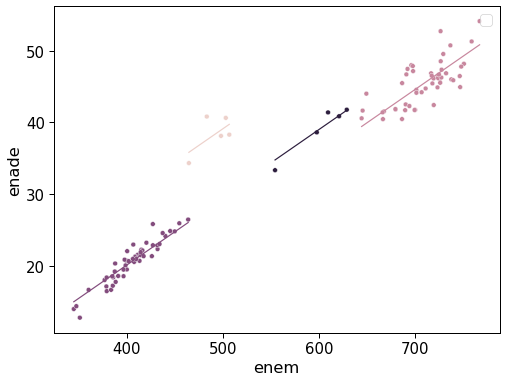

In [6]:
fig = plt.figure(figsize=(8,6))
ax = sns.scatterplot(data = model.data, x='enem',y='enade',hue='curso')
sns.lineplot(data = model.data,x='enem',y='fits',hue='curso',ax=ax)
plt.legend([])

In the simulated data above, we depict four hypothecical courses with different kinds of students. It stands to reason the students of course 4 would score worse on the exit ENADE exam then the students of course 2. To take account of these differences in student characteristics, the IDD should "take into acccount" ou "control for" these differences. If, and this is obviously an unrealistic assumption, all differences not related to the quality of the course can be taken into account by the ENEM entrance exam, then we can calculate an aggregated value measure using the residuals of a regression on ENADE on ENEM. 

## Calculations of the IDD

The INEP method takes the multilevel (or "random intercept") model and calculates the IDD as the mean of the residuals. This, of course, doesn't make any sense. In the next few cells we will load the microdata of INEP, look at some summary statistics and see if we can replicate INEPs faulty calculations, with the aim to compare them to the correct way to calculate the IDD

In [5]:
# IDD microdata. The stated conditions for having a IDD divulged are Ncurso > 1 and 
# fraction of participantes with ENEM found > 0.2 (IDD = SC otherwise).
# But we cant't get the fraction from the microdata
def getdata(ano,Nmin = 2):
    df = pd.read_csv("data/processed/idd-microdata-{}.csv".format(ano))
    df['anosgrad'] = df['ano'] - df['ingresso']
    df['enem'] = (df['mt'] + df['lc'] + df['ch'] + df['cn'])/4 # note that any missing enem subgrade will give a missing 'enem'
    df['ncurso'] = df.groupby('curso')['ano'].transform(lambda x: len(x))
    df = df[df['ncurso'] >= Nmin] # don't use courses with less than Nmin participants
    
    return df

In [6]:
# md = microdata
md19 = getdata(2019)
print(len(md19))
md19.sample(5)

291286


,ano,ies,catadm,orgacad,area,curso,municipio,tp_inscricao,ingresso,tp_pres,nota,anoenem,cn,ch,lc,mt,adm,anosgrad,enem,ncurso
179955,2019,4586,4,10022,23,118364,5218003,1,2015,555,25.6,2014,403.7,542.1,498.4,342.8,priv_cfl,4,446.750,20
7685,2019,22,5,10028,21,2016,3550308,1,2014,555,66.0,2012,564.1,711.2,629.9,622.9,priv_sfl,5,632.025,346
85312,2019,878,5,10020,36,43988,3131307,1,2015,555,42.5,2014,499.3,598.5,451.2,387.7,priv_sfl,4,484.175,48
104256,2019,592,1,10028,6002,63832,3138203,1,2014,555,41.3,2013,435.7,510.0,461.6,515.6,pub,5,480.725,72
147583,2019,549,1,10028,6405,99839,1200203,1,2014,555,33.9,2013,374.1,412.6,454.3,551.8,pub,5,448.200,22


In [7]:
# Let's characterize the data, to get an idea what we're dealing with
def summarize(data):
    ano = data['ano'][0]
    N = len(data)
    Ncursos = len(data.curso.unique())
    print("{}: {} students in {} unique courses".format(ano,N,Ncursos))
    print("ENADE: mean and std\n",data.nota.mean(),data.nota.std())
    print("ENEM: mean and std\n",data.enem.mean(),data.enem.std())
    print("\n")

summarize(md19)

2019: 291286 students in 7978 unique courses
ENADE: mean and std
 45.635384810804496 14.379530111551206
ENEM: mean and std
 559.9652921870601 80.57816463192484




In [8]:
# Published course IDD (only available from 2016 as a separate spreadsheet, 
# must use the CPC spreadsheets for 2014 and 2015).
inep19 = pd.read_csv('data/processed/idd-pub-2019.csv')

# Published course CPC (which includes a columns for "gross IDD")
#cpc17 = pd.read_csv('data/processed/cpc-pub-2017.csv')

def filtered(df,Nmin = 2):
    df = df[df['N'] >= Nmin]
    df = df[df['fracN'] >= 0.2]
    df = df.dropna(subset=['idd_faixa'])
    return df

finep19 = filtered(inep19)
print(len(inep19),len(finep19),finep19['N'].sum())
finep19.sample(5)


8368 7978 291286


,area,ca,curso,modalidade,N,fracN,idd,iddc,idd_faixa,ano
5232,95,Privada com fins lucrativos,1184872,Educação Presencial,21,0.617647,-0.6397,2.1470,3,2019
8274,6405,Pública Federal,139,Educação Presencial,71,0.845238,-0.4570,1.8053,2,2019
2135,28,Privada com fins lucrativos,1283695,Educação Presencial,35,0.897436,-0.8183,1.9239,2,2019
604,6008,Pública Federal,105436,Educação Presencial,54,0.931034,-0.1675,2.2963,3,2019
2538,19,Privada com fins lucrativos,18984,Educação Presencial,24,0.827586,1.7701,3.4486,4,2019


In [9]:
for area in finep19.area.unique():
    data = finep19.query("area == @area")
    print("Mean IDD = {:.2f}, Std = {:.1f}, Range = {:.1f}".format(data['idd'].mean(),data['idd'].std(),data['idd'].max()-data['idd'].min()))

Mean IDD = 0.04, Std = 1.3, Range = 12.7
Mean IDD = -0.05, Std = 2.1, Range = 24.5
Mean IDD = -0.01, Std = 1.5, Range = 21.8
Mean IDD = -0.00, Std = 0.9, Range = 7.7
Mean IDD = 0.03, Std = 1.5, Range = 13.0
Mean IDD = -0.08, Std = 0.8, Range = 9.4
Mean IDD = -0.16, Std = 1.2, Range = 10.4
Mean IDD = 0.01, Std = 1.4, Range = 21.0
Mean IDD = 0.01, Std = 1.5, Range = 20.8
Mean IDD = -0.25, Std = 0.9, Range = 9.2
Mean IDD = -0.02, Std = 1.4, Range = 14.5
Mean IDD = 0.19, Std = 2.1, Range = 16.8
Mean IDD = 0.25, Std = 2.0, Range = 14.7
Mean IDD = -0.42, Std = 3.6, Range = 19.1
Mean IDD = 0.01, Std = 1.5, Range = 18.1
Mean IDD = -0.09, Std = 1.9, Range = 17.5
Mean IDD = 0.06, Std = 1.4, Range = 7.0
Mean IDD = 0.06, Std = 2.4, Range = 31.2
Mean IDD = 0.14, Std = 1.7, Range = 13.3
Mean IDD = 0.12, Std = 2.6, Range = 15.8
Mean IDD = 0.07, Std = 2.3, Range = 14.8
Mean IDD = 0.09, Std = 2.4, Range = 22.1
Mean IDD = -0.08, Std = 2.7, Range = 16.8
Mean IDD = 0.04, Std = 2.3, Range = 18.7
Mean IDD =

In [10]:
# courses in the spreadsheet, but not in the microdata
print(len(set(inep19.curso) - set(md19.curso) ))
# courses in the filtered spreadsheet (N>1, fracN > 0.2, but not in the microdata
print(len(set(filtered(inep19).curso) - set(md19.curso) ))


390
0


## Calculation of the IDD with the microdata
To see if we can reproduce INEP's calcultations. We'll use the Lmer function of R, through the Pymer interface, to calculate the linear mixed effects model.

In [11]:
from pymer4.models import Lmer
formula = 'nota ~  ch + cn + mt + lc + (1|curso)'
model1 = Lmer(formula,data=md19.query("area == 12"))
model1.fit()

Formula: nota~ch+cn+mt+lc+(1|curso)

Family: gaussian	 Inference: parametric

Number of observations: 19471	 Groups: {'curso': 232.0}

Log-likelihood: -70735.961 	 AIC: 141471.921

Random effects:

                 Name     Var    Std
curso     (Intercept)   6.378  2.525
Residual               81.687  9.038

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),11.943,9.670,14.216,1.160,11305.310,10.297,0.0,***
ch,0.020,0.017,0.023,0.002,19463.961,12.647,0.0,***
cn,0.008,0.004,0.011,0.002,19461.387,4.390,0.0,***
mt,0.013,0.011,0.015,0.001,19463.724,11.741,0.0,***
lc,0.030,0.027,0.033,0.002,19459.909,17.953,0.0,***


In [12]:
import numpy as np
from pymer4.models import Lmer
import scipy.stats as stats

def multilevel(data,residcomoutlier = True):
    '''Retorna modelo1 (estimado com outliers) e modelo2 (estimado sem outliers).
    Retorna também os dados originais (com outliers!) e os residuos (calculado 
    pela diferença entre a nota original com a nota prevista pelo modelo2)
    
    Sim, isso não faz sentido.
    '''
    removeroutliers = True
    
    formula = 'nota ~  ch + cn + mt + lc + (1|curso)'
    model1 = Lmer(formula,data=data)
    _ = model1.fit(summarize=False);
    if removeroutliers:
        newdata = model1.data.copy()
        newdata['z'] = stats.zscore(newdata.residuals,ddof=1)
        newdata = newdata[abs(newdata.z) <= 3]
        model2 = Lmer(formula,data=newdata)
        _ = model2.fit(summarize=False);
    else:
        model2 = model1
    
    model2.data = model2.data.rename(columns={'residuals':'resid'})
    if residcomoutlier:
        # Descobri que para reproduzir melhor os número do INEP, é preciso
        # *incluir* as notas dos outliers no cálculo do IDD (!)
        # Ou seja, vamos calcular a nota prevista pelo modelo2 (estimado sem outliers)
        # usando os todos os dados, incluindo outliers
        model1.data['pred'] = model2.predict(model1.data,use_rfx=True)
        model1.data['resid'] = model1.data.nota - model1.data.pred
        fitdata = model1.data.copy()
    else:
        fitdata = model2.data.copy()
    
    return model2,fitdata
    
def idd_multilevel(data,Nmin=2,to_disk=False,verbose=False,residcomoutlier=True):
    'returns the idds calculated acording to INEP and also the correct way, using the random intercepts'
    #data = data.query("ncurso >= @Nmin")
    data = data.groupby('curso').filter(lambda x: len(x) >= Nmin)
    Ncursos = data.curso.nunique()
    if Ncursos < 2 or data.empty:
        return None,None,None
    area = data.area.iloc[0]
    if verbose:
        print("Area {}, with Nmin {} and Ncursos {}".format(area,Nmin,Ncursos))
    model,fitdata = multilevel(data,residcomoutlier)
    d = {}
    for key in ['ml','intercept','noranef']:
        if key == 'ml':
            d[key] = fitdata.groupby('curso').agg({'resid':['mean','size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})
        elif key == 'intercept':
            agg = fitdata.groupby('curso',as_index=False).agg({'resid':['size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})
            agg.columns = ['curso','N','std','enem.mean','ies','municipio','adm']
            #agg.index = agg.index.astype(str)
            d[key] = model.ranef.join(agg)
            d[key] = d[key].set_index('curso')
        elif key == 'noranef':
            model.data['pred'] = model.predict(model.data,use_rfx=False)
            model.data['resid'] = model.data.nota - model.data.pred
            d[key] = model.data.groupby('curso').agg({'resid':['mean','size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})

    
        d[key].columns = ['idd','N','std','enem.mean','ies','municipio','adm']
        d[key]['stderr'] = d[key]['std']/np.sqrt(d[key]['N'])
        #d[key].sort_values('idd',ascending=False,inplace=True)
        #d[key].insert(0,'rank',range(1,len(d[key])+1))
        area = data['area'].iloc[0]
        ano = data['ano'].iloc[0]
        d[key]['area'] = area
        d[key]['ano'] = ano

        if to_disk:
            fn = 'data/calculated/idd-'+key+'-'+str(ano)+'-'+str(area)+'-nmin-'+str(Nmin)+'.csv'
            d[key].reset_index().to_csv(fn,index=False)
    return d['ml'],d['intercept'],d['noranef']


## Calculate all areas

In [13]:
# This takes some time. With the option to_disk=True, the calculations are written to disk (data/calculated)
areas = md19.area.unique()
for area in areas:
    data = md19.query("area == @area")
    ml,intercept,noranef = idd_multilevel(data,Nmin = 2,to_disk=True,verbose=True,residcomoutlier=True)

Area 5710, with Nmin 2 and Ncursos 715
Area 17, with Nmin 2 and Ncursos 295
Area 6405, with Nmin 2 and Ncursos 64
Area 12, with Nmin 2 and Ncursos 232
Area 5806, with Nmin 2 and Ncursos 431
Area 23, with Nmin 2 and Ncursos 787
Area 28, with Nmin 2 and Ncursos 413
Area 5, with Nmin 2 and Ncursos 214
Area 21, with Nmin 2 and Ncursos 394
Area 5902, with Nmin 2 and Ncursos 368
Area 6, with Nmin 2 and Ncursos 237
Area 6008, with Nmin 2 and Ncursos 180
Area 19, with Nmin 2 and Ncursos 425
Area 36, with Nmin 2 and Ncursos 512
Area 4003, with Nmin 2 and Ncursos 166
Area 6002, with Nmin 2 and Ncursos 79
Area 51, with Nmin 2 and Ncursos 94
Area 27, with Nmin 2 and Ncursos 73
Area 5814, with Nmin 2 and Ncursos 175
Area 6208, with Nmin 2 and Ncursos 610
Area 6307, with Nmin 2 and Ncursos 264
Area 3501, with Nmin 2 and Ncursos 455
Area 55, with Nmin 2 and Ncursos 297
Area 69, with Nmin 2 and Ncursos 106
Area 92, with Nmin 2 and Ncursos 91
Area 95, with Nmin 2 and Ncursos 186
Area 90, with Nmin 2 an

## Comparision of our calculations with the INEP spreadsheet

In [14]:
def compare_methods(areas):
    comps = []
    for area in areas:
        fn = "idd-ml-2019-{}-nmin-2.csv".format(area)
        ml = pd.read_csv('data/calculated/'+fn)
        comp = pd.merge(ml,finep19,on='curso')
        comp['diff'] = comp['idd_x'] - comp['idd_y']
        comp['absdiff'] = abs(comp['diff'])
        comps.append(comp)
        
    return pd.concat(comps)

areas = md19.area.unique()
comps = compare_methods(areas)
comps.to_csv('data/calculated/comps.csv',index=False)

In [15]:
comps = pd.read_csv('data/calculated/comps.csv')

In [16]:
comps['reldiff'] = comps['absdiff'] / comps.groupby('area_x')['idd_x'].transform(lambda x:x.max() - x.min())
comps.sample(4)

,curso,idd_x,N_x,std,enem.mean,ies,municipio,adm,stderr,area_x,...,modalidade,N_y,fracN,idd_y,iddc,idd_faixa,ano_y,diff,absdiff,reldiff
1622,1177368,-1.307503,28,7.134580,539.087500,1774,4119905,priv_cfl,1.348309,5806,...,Educação Presencial,28,0.666667,-1.3102,2.0522,3,2019,0.002697,0.002697,0.000087
7025,1156532,2.033913,20,8.265215,524.181250,1244,3205309,priv_cfl,1.848158,3501,...,Educação Presencial,20,0.869565,2.0425,3.5246,4,2019,-0.008587,0.008587,0.000490
3246,20719,0.779150,56,7.528686,583.767857,1244,3205309,priv_cfl,1.006063,21,...,Educação Presencial,56,0.903226,0.7775,2.8795,3,2019,0.001650,0.001650,0.000114
672,1295066,-0.454999,20,12.121178,582.986250,1812,1302603,pub,2.710378,5710,...,Educação Presencial,20,0.952381,-0.4546,2.3562,3,2019,-0.000399,0.000399,0.000018


In [17]:
abs_threshold = 0.01
rel_threshold = 0.05
for area in areas:
    comp = comps.query("area_x == @area")
    dc = comp.query("absdiff > @abs_threshold" )
    rc = comp.query("reldiff > @rel_threshold" )
    print("Our calculations don't agree with INEP with at least {} (absolute on the ENADE scale) for {} out of {} ({:.1f}%) courses in area {}".format(abs_threshold,len(dc),len(comp),len(dc)/len(comp)*100,area))
    print("Our calculations don't agree with INEP with at least {} (relative to IDD range) for {} out of {} ({:.1f}%) courses in area {}\n".format(rel_threshold,len(rc),len(comp),len(rc)/len(comp)*100,area))

Our calculations don't agree with INEP with at least 0.01 (absolute on the ENADE scale) for 8 out of 715 (1.1%) courses in area 5710
Our calculations don't agree with INEP with at least 0.05 (relative to IDD range) for 0 out of 715 (0.0%) courses in area 5710

Our calculations don't agree with INEP with at least 0.01 (absolute on the ENADE scale) for 4 out of 295 (1.4%) courses in area 17
Our calculations don't agree with INEP with at least 0.05 (relative to IDD range) for 0 out of 295 (0.0%) courses in area 17

Our calculations don't agree with INEP with at least 0.01 (absolute on the ENADE scale) for 0 out of 64 (0.0%) courses in area 6405
Our calculations don't agree with INEP with at least 0.05 (relative to IDD range) for 0 out of 64 (0.0%) courses in area 6405

Our calculations don't agree with INEP with at least 0.01 (absolute on the ENADE scale) for 1 out of 232 (0.4%) courses in area 12
Our calculations don't agree with INEP with at least 0.05 (relative to IDD range) for 0 out 

In [18]:
pd.options.display.float_format = '{:,.7f}'.format
comps[['idd_x','idd_y']].corr()

,idd_x,idd_y
idd_x,1.0000000,0.9990083
idd_y,0.9990083,1.0000000


In [19]:
comps.groupby('area_x')[['idd_x','idd_y']].corr().iloc[0::2,-1].sort_values()

area_x       
19      idd_x   0.9970074
6       idd_x   0.9970329
95      idd_x   0.9975152
55      idd_x   0.9979685
92      idd_x   0.9989377
6410    idd_x   0.9989498
6208    idd_x   0.9989659
23      idd_x   0.9989829
5814    idd_x   0.9992349
5902    idd_x   0.9992380
51      idd_x   0.9992743
36      idd_x   0.9993031
3501    idd_x   0.9993316
4003    idd_x   0.9993933
5806    idd_x   0.9993939
6307    idd_x   0.9994395
17      idd_x   0.9995302
5710    idd_x   0.9995749
28      idd_x   0.9995787
5       idd_x   0.9996241
21      idd_x   0.9997454
12      idd_x   0.9998469
6008    idd_x   0.9999922
6405    idd_x   1.0000000
6002    idd_x   1.0000000
27      idd_x   1.0000000
90      idd_x   1.0000000
69      idd_x   1.0000000
91      idd_x   1.0000000
Name: idd_y, dtype: float64

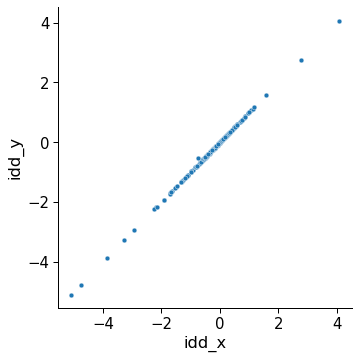

In [21]:
comp = comps.query("area_x == 12")
sns.relplot(data=comp,x='idd_x',y='idd_y')

## The intercepts compared to INEP IDDs
As is clear from our explanation above, the intercept estimate for the value added of a course is much more spread out the the values INEP calculates, since the latter uses residuals that vary around the intercept. 

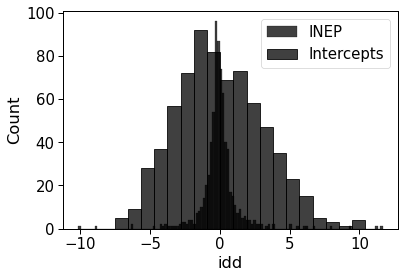

In [22]:
p = sns.color_palette(['black','gray'])
sns.set_palette(p)

area = 5710
fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
intercept = pd.read_csv('data/calculated/'+fn)
fn = "idd-ml-2019-{}-nmin-2.csv".format(area)
ml = pd.read_csv('data/calculated/'+fn)

ax = sns.histplot(ml['idd'],label="INEP")
sns.histplot(intercept['idd'],label="Intercepts",ax=ax)
plt.legend()

## Comparison of the model with data of selected courses

In [1]:
area = 5
data = data19.query("area == @area")
model,fitdata = multilevel(data)
ml,intercept,noranef = idd_multilevel(data,Nmin = 2,to_disk=True,verbose=True,residcomoutlier=True)

NameError: name 'data19' is not defined

In [693]:
fitdata['prednoranef'] = model.predict(fitdata,use_rfx=False)
fitdata['pred'] = model.predict(fitdata,use_rfx=True)

In [704]:
intercept.sort_values(by='idd').iloc[-5].name

1108311

<AxesSubplot:xlabel='enem', ylabel='nota'>

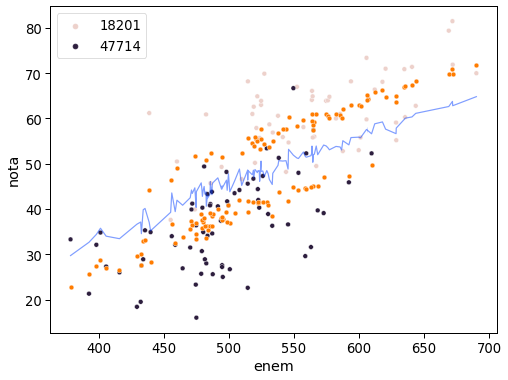

In [712]:
course1 = intercept.sort_values(by='idd').iloc[-1].name
course2 = intercept.sort_values(by='idd').iloc[1].name
sns.set_context('paper',font_scale=1.5)
fig = plt.figure(figsize=(8,6))
sns.set_palette('bright')
datatoplot = fitdata.query("curso == @course1 or curso == @course2")
ax = sns.scatterplot(data=datatoplot,x='enem',y='nota',hue='curso')
sns.scatterplot(data=datatoplot,x='enem',y='pred',ax=ax)
sns.lineplot(data=datatoplot,x='enem',y='prednoranef',alpha=0.5,ax=ax)

But these plots are not so didactical. For expository reasons, maybe it's better to explore the simplified model. Below, we use real data, but a model with just the one dimensional ENEM grade. 

/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


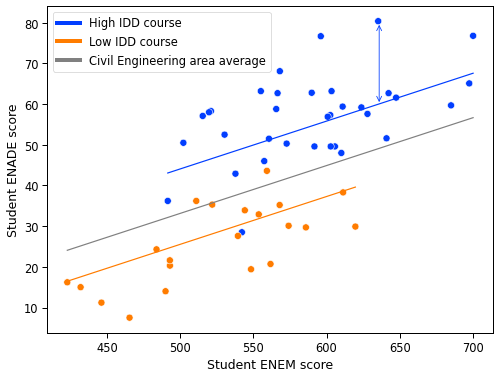

In [28]:
def multilevel_simple(data,residcomoutlier = True):
    '''Retorna modelo1 (estimado com outliers) e modelo2 (estimado sem outliers).
    Retorna também os dados originais (com outliers!) e os residuos (calculado 
    pela diferença entre a nota original com a nota prevista pelo modelo2)
    
    Sim, isso não faz sentido.
    '''
    removeroutliers = True
    
    formula = 'nota ~  enem + (1|curso)'
    model1 = Lmer(formula,data=data)
    _ = model1.fit(summarize=False);
    if removeroutliers:
        newdata = model1.data.copy()
        newdata['z'] = stats.zscore(newdata.residuals,ddof=1)
        newdata = newdata[abs(newdata.z) <= 3]
        model2 = Lmer(formula,data=newdata)
        _ = model2.fit(summarize=False);
    else:
        model2 = model1
    
    model2.data = model2.data.rename(columns={'residuals':'resid'})
    if residcomoutlier:
        # Descobri que para reproduzir melhor os número do INEP, é preciso
        # *incluir* as notas dos outliers no cálculo do IDD (!)
        # Ou seja, vamos calcular a nota prevista pelo modelo2 (estimado sem outliers)
        # usando os todos os dados, incluindo outliers
        model1.data['pred'] = model2.predict(model1.data,use_rfx=True)
        model1.data['resid'] = model1.data.nota - model1.data.pred
        data = model1.data
    else:
        data = model2.data
    
    return model2,data

area = 5710 # Civil Engineering
data = md19.query("area == @area")
model_simple,fitdata = multilevel_simple(data)
agg = fitdata.groupby('curso',as_index=False).agg({'resid':['size','std'],'enem':'mean','ies':'first','municipio':'first','adm':'first'})
intercept = model_simple.ranef.join(agg)
intercept.columns = ['idd','curso','N','std','enem.mean','ies','municipio','adm']
intercept = intercept.set_index('curso')

course1 = intercept.sort_values(by='idd').iloc[-1].name
course2 = intercept.sort_values(by='idd').iloc[0].name
fitdata['prednoranef'] = model_simple.predict(fitdata,use_rfx=False)
fitdata['pred'] = model_simple.predict(fitdata,use_rfx=True)
sns.set_context('paper',font_scale=1.3)
p = sns.color_palette('bright',2)
fig = plt.figure(figsize=(8,6))
datatoplot = fitdata.query("curso == @course1 or curso == @course2")
ax = sns.scatterplot(data=datatoplot,x='enem',y='nota',hue='curso',palette=p,s=50)
sns.lineplot(data=datatoplot,x='enem',y='pred',hue='curso',palette=p,ax=ax)
ax.annotate("",xy=(636,60),xytext=(636,80),arrowprops=dict(arrowstyle='<->',color=p[0]))
sns.lineplot(data=datatoplot,x='enem',y='prednoranef',ax=ax,color='gray',label="Area average")
ax.set_xlabel("Student ENEM score")
ax.set_ylabel("Student ENADE score")
#ax.legend(['Course 1','Course 2','Area average'])
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=p[0], lw=4),
                Line2D([0], [0], color=p[1], lw=4),
                Line2D([0], [0], color="gray", lw=4)]

ax.legend(custom_lines, ['High IDD course', 'Low IDD course', 'Civil Engineering area average'])

for dpi in [50,300]:
     fn = 'figs/simple-model-{}-{}.png'.format(area,dpi)
     plt.savefig(fn,dpi=dpi)

## Comparison and correlations between methods

In [29]:
area = 12 
fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
intercept = pd.read_csv('data/calculated/'+fn)
fn = "idd-ml-2019-{}-nmin-2.csv".format(area)
ml = pd.read_csv('data/calculated/'+fn)
corrs = pd.merge(ml,intercept,on="curso")
print("Correlation between INEP and Intercept method of area {}: {:.2f}".format(area,corrs[['idd_x','idd_y']].corr().iloc[0,1]))

Correlation between INEP and Intercept method of area 12: 0.62


In [30]:
areas = md19.area.unique()
for area in areas:
    fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
    intercept = pd.read_csv('data/calculated/'+fn)
    fn = "idd-ml-2019-{}-nmin-2.csv".format(area)
    ml = pd.read_csv('data/calculated/'+fn)
    corrs = pd.merge(ml,intercept,on="curso")
    print("Correlation between INEP and Intercept method of area {}: {:.2f}".format(area,corrs[['idd_x','idd_y']].corr(method="pearson").iloc[0,1]))

Correlation between INEP and Intercept method of area 5710: 0.59
Correlation between INEP and Intercept method of area 17: 0.73
Correlation between INEP and Intercept method of area 6405: 0.83
Correlation between INEP and Intercept method of area 12: 0.62
Correlation between INEP and Intercept method of area 5806: 0.65
Correlation between INEP and Intercept method of area 23: 0.69
Correlation between INEP and Intercept method of area 28: 0.69
Correlation between INEP and Intercept method of area 5: 0.73
Correlation between INEP and Intercept method of area 21: 0.66
Correlation between INEP and Intercept method of area 5902: 0.53
Correlation between INEP and Intercept method of area 6: 0.58
Correlation between INEP and Intercept method of area 6008: 0.65
Correlation between INEP and Intercept method of area 19: 0.73
Correlation between INEP and Intercept method of area 36: 0.62
Correlation between INEP and Intercept method of area 4003: 0.72
Correlation between INEP and Intercept method

## Comparison of course categories (1-5) between methods
How do the INEP quality indicators assigned to courses lead to real word conseguences? To communicate the indicators to society, the raw IDD scores are converted to a 1-5 categorical scale. The 3-5 categories are considered adequate or above whereas the 1-2 categories are considered not adequate. If the CPC composite indicator (in which the IDD indicator has the largest weight, 35%) is in the 1-2 category, this will lead to an in-house visit as a condition for the renovation of recognization of the course. 

Note that to reproduce INEP classification, (see the funtion norm_rescale below) we need to 
1. calculate z-scores with the standard deviation of the complete sample
2. use zmin and zmax such that they are > -3 and < 3 resp.
3. but don't change standard deviation, use the complete sample std to rescale to 0 - 5 (and outliers get 0 and 5)

In [31]:
def tofaixa(c):
    if c < 0.945:
        return '1'
    elif c < 1.945:
        return '2'
    elif c < 2.945:
        return '3'
    elif c < 3.945:
        return '4'
    else:
        return '5'
    
def dist_params(idds,verbose=False):
    'returns new idds, mean, std, zmin and zmax'
    
    df = pd.DataFrame({'idd':idds,'z':stats.zscore(idds,ddof=1)})
    df_f = df[(df['z'] < 3) & (df['z'] > -3)]
    noutliers = len(df) - len(df_f)
    if verbose:
        print("Outliers: ",noutliers)
    
    #we are calculating iddc with the original mean and std
    #mean,std = df_f['idd'].mean(),df_f['idd'].std(ddof=1)
    minz,maxz = df_f['z'].min(),df_f['z'].max()
    
    return idds.mean(),idds.std(ddof=1),minz,maxz
        
def norm_rescale(idds):
    'assigns a columns conceito 1-5'
    mean,std,minz,maxz = dist_params(idds)
    #print(mean,std,minz,maxz)
    z = stats.zscore(idds,ddof=1)
    iddc = 5*(z-minz)/(maxz-minz)
    iddc = np.where(iddc > 0,iddc,0)
    iddc = np.where(iddc < 5,iddc,5)

    return iddc

def cutoffs_on_idd_scale(idds):
    'return 4 cut-offs of 1-5 categories, on the orginal idd scale'
    mean,std,zmin,zmax = dist_params(idds)
    #print(mean,std,zmin,zmax)
    c1 = mean + std*(0.945*(zmax-zmin)/5+zmin)
    c2 = mean + std*(1.945*(zmax-zmin)/5+zmin)
    c3 = mean + std*(2.945*(zmax-zmin)/5+zmin)
    c4 = mean + std*(3.945*(zmax-zmin)/5+zmin)
    return c1,c2,c3,c4

In [20]:
finep19 = filtered(inep19)
area = 12
finepa = finep19.query('area == @area')
finepa['iddc2'] = norm_rescale(finepa['idd'])
finepa['faixa2'] = finepa['iddc2'].apply(tofaixa)
c1,c2,c3,c4 = cutoffs_on_idd_scale(finepa['idd'])
print(c1,c2,c3,c4)

finepa.sort_values(by='idd',ascending=True)[:20]


std incial =  0.9142028105076633
std final =  0.66335332298663
std incial =  0.9142028105076633
std final =  0.66335332298663
-2.0846399 -1.1824598999999998 -0.28027990000000025 0.6219000999999996


/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ewout/.conda/envs/idd/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,area,ca,curso,modalidade,N,fracN,idd,iddc,idd_faixa,ano,iddc2,faixa2
116,12,Pública Federal,53338,Educação Presencial,71,0.972603,-5.0939,0.0000,1,2019,0.000000,1
3964,12,Privada com fins lucrativos,5001183,Educação Presencial,10,0.370370,-4.7682,0.0000,1,2019,0.000000,1
75,12,Privada com fins lucrativos,98409,Educação Presencial,38,0.844444,-3.8642,0.0000,1,2019,0.000000,1
6449,12,Privada sem fins lucrativos,7705,Educação Presencial,108,1.000000,-3.2721,0.0000,1,2019,0.000000,1
731,12,Pública Estadual,19086,Educação Presencial,26,0.896552,-2.9372,0.0000,1,2019,0.000000,1
4008,12,Privada sem fins lucrativos,65114,Educação Presencial,73,0.730000,-2.2432,0.7693,1,2019,0.769248,1
8258,12,Privada com fins lucrativos,51835,Educação Presencial,115,0.877863,-2.1752,0.8446,1,2019,0.844621,1
1020,12,Pública Estadual,72417,Educação Presencial,50,0.892857,-2.1499,0.8727,1,2019,0.872664,1
3162,12,Privada com fins lucrativos,1190621,Educação Presencial,27,0.964286,-1.9296,1.1169,2,2019,1.116850,2
8099,12,Pública Federal,14093,Educação Presencial,103,0.980952,-1.9227,1.1245,2,2019,1.124498,2


## Graphical comparision between the INEP and the Intercept method
A first indication that the IDD are not reliable is looking at a funnel plot, that is, the IDD as a function of the number of students for a course.

Area 5710, with Nmin 2 and Ncursos 715
CPU times: user 24.6 s, sys: 8.22 s, total: 32.8 s
Wall time: 24.2 s


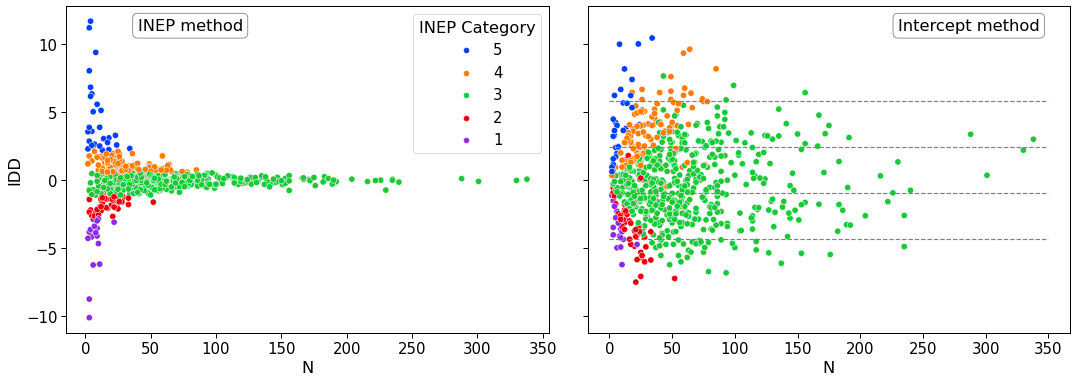

In [33]:
area = 5710
data = md19.query("area == @area")
%time ml,intercept,noranef = idd_multilevel(data,Nmin = 2,to_disk=True,verbose=True,residcomoutlier=True)

inep19 = pd.read_csv('data/processed/idd-pub-2019.csv')
finep19 = filtered(inep19)
finep19a = finep19.query("area == @area")
ml = ml.join(finep19a.set_index('curso')['idd_faixa'])
intercept = intercept.join(finep19a.set_index('curso')['idd_faixa'])

#cmap=plt.cm.get_cmap('viridis',5)
#sns.set_palette([cmap(x) for x in range(1,6)])
sns.set_palette('bright',5)
psize=40

sns.set_context('paper',font_scale=1.7)
fig,axs = plt.subplots(1,2,figsize=(18,6),sharey=True)
hue_order = ['5','4','3','2','1']
sns.scatterplot(data=finep19a,x='N',y='idd',hue='idd_faixa',hue_order=hue_order,s=psize,ax=axs[0])

#c1,c2,c3,c4 = cutoffs_on_idd_scale(finep19a['idd'])
#axs[0].hlines([c1,c2,c3,c4],0,350)
axs[0].set_ylabel("IDD")

#axs[0].legend(loc='lower right')
leg = axs[0].get_legend()
leg.set_title("INEP Category")

sns.scatterplot(data=intercept,x='N',y='idd',hue='idd_faixa',hue_order=hue_order,legend=False,s=psize,ax=axs[1])


axs[0].text(40,11,"INEP method", color='black',bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round'))
axs[1].text(230,11,"Intercept method", color='black',bbox=dict(facecolor='none',edgecolor='gray',boxstyle='round'))

c1,c2,c3,c4 = cutoffs_on_idd_scale(intercept['idd'])
axs[1].hlines([c1,c2,c3,c4],0,350,colors='gray',linestyles='dashed')
plt.subplots_adjust(wspace=0.08)

for dpi in [50,300]:
     fn = 'figs/idd-comp-{}-{}.png'.format(area,dpi)
     plt.savefig(fn,dpi=dpi)

This looks like a random number generator, something we don't see with the intercept method (right) or the means of the ENADE grade (below)

Let's look at the number of courses classified as in categories 1-2 that moved up and vice versa.

In [34]:
inep19 = pd.read_csv('data/processed/idd-pub-2019.csv')
finep19 = filtered(inep19)

areas = md19.area.unique()
for area in areas:
    fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
    intercept = pd.read_csv('data/calculated/'+fn)
    finep19a = finep19.query("area == @area")
    intercept = pd.merge(intercept,finep19a[['curso','idd_faixa']],on='curso',how='left')
    
    c1,c2,c3,c4 = cutoffs_on_idd_scale(intercept['idd'])
    onetwo = len(intercept.query("idd_faixa == '1' | idd_faixa == '2'"))
    above = len(intercept.query("idd_faixa == '3' | idd_faixa == '4' | idd_faixa == '5'"))
    total = onetwo + above
    moveup = len(intercept.query("(idd_faixa == '1' | idd_faixa == '2') & idd > @c2"))
    movedown = len(intercept.query("(idd_faixa == '3' | idd_faixa == '4' | idd_faixa == '5') & idd < @c2"))
    print("Of a total of {} courses in area {} ({} below and {} and above category '3'), {} moved up ({:.1f}%) and {} moved down ({:.1f}%).".format(total,area,onetwo,above,moveup,moveup/total*100,movedown,movedown/total*100))
    print("INEP:")
    dist_params(finep19a['idd'],verbose=True)
    print("Intercept:")
    dist_params(intercept['idd'],verbose=True)

Of a total of 715 courses in area 5710 (65 below and 650 and above category '3'), 4 moved up (0.6%) and 231 moved down (32.3%).
INEP:
Outliers:  15
Intercept:
Outliers:  4
Of a total of 295 courses in area 17 (45 below and 250 and above category '3'), 15 moved up (5.1%) and 35 moved down (11.9%).
INEP:
Outliers:  3
Intercept:
Outliers:  1
Of a total of 64 courses in area 6405 (25 below and 39 and above category '3'), 3 moved up (4.7%) and 0 moved down (0.0%).
INEP:
Outliers:  0
Intercept:
Outliers:  0
Of a total of 232 courses in area 12 (25 below and 207 and above category '3'), 9 moved up (3.9%) and 33 moved down (14.2%).
INEP:
Outliers:  6
Intercept:
Outliers:  1
Of a total of 431 courses in area 5806 (48 below and 383 and above category '3'), 4 moved up (0.9%) and 117 moved down (27.1%).
INEP:
Outliers:  12
Intercept:
Outliers:  5
Of a total of 787 courses in area 23 (112 below and 675 and above category '3'), 10 moved up (1.3%) and 172 moved down (21.9%).
INEP:
Outliers:  18
Inter

Let' try the same analysis in a different way.

In [34]:
area = 12
fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
intercept = pd.read_csv('data/calculated/'+fn)
finep19a = finep19.query("area == @area")
intercept = pd.merge(intercept,finep19a[['curso','idd_faixa']],on='curso',how='left')
intercept['idd_conceito'] = norm_rescale(intercept['idd'])
intercept['idd_faixa_new'] = intercept['idd_conceito'].apply(tofaixa)
len(intercept.query("(idd_faixa != '2' & idd_faixa != '1') & (idd_faixa_new == '1' | idd_faixa_new == '2')"))

33

Ok, it's the same result. Good.

Just a quick graph to show that the ENADE vs N graph does not show the typical funnel shape of a random number generator.

<AxesSubplot:xlabel='N', ylabel='enade'>

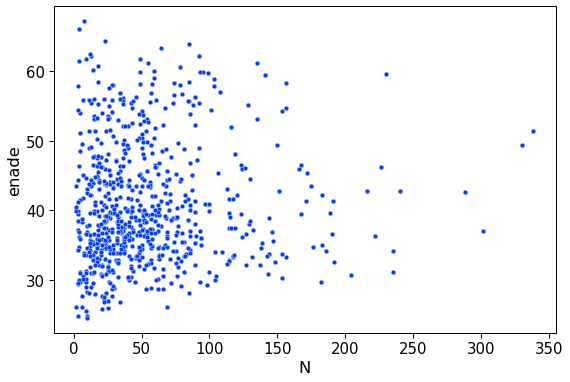

In [35]:
fig,ax = plt.subplots(1,1,figsize=(9,6),sharey=True)
enademeans = data.groupby('curso').agg({'nota':['mean','size']})
enademeans.columns = ['enade','N']
sns.scatterplot(data=enademeans,x='N',y='enade',ax=ax)

A graph of the two IDDs plotted against rank.

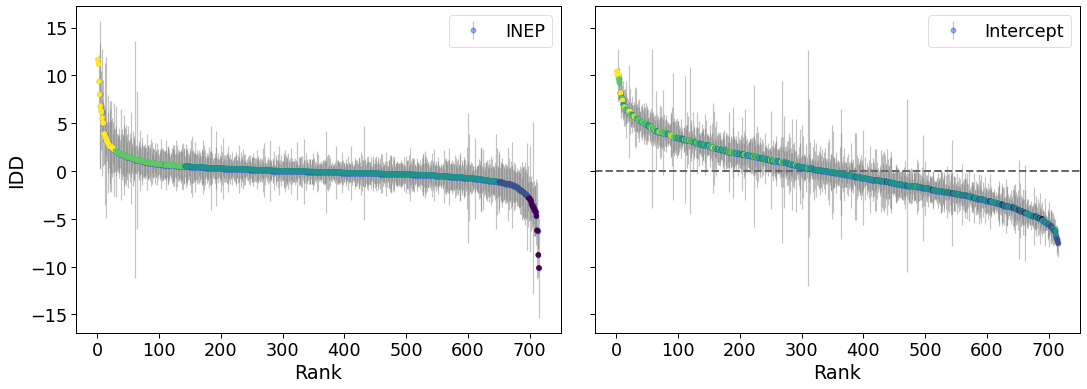

In [37]:
area = 5710
fn = "idd-intercept-2019-{}-nmin-2.csv".format(area)
intercept = pd.read_csv('data/calculated/'+fn)
finep19a = finep19.query("area == @area")
intercept = pd.merge(intercept,finep19a[['curso','idd_faixa']],on='curso',how='left')
fn = "idd-ml-2019-{}-nmin-2.csv".format(area)
ml = pd.read_csv('data/calculated/'+fn)
ml = pd.merge(ml,finep19a[['curso','idd_faixa']],on='curso',how='left')

fig,axs = plt.subplots(1,2,figsize=(18,6),sharey=True)
interceptr = intercept.copy()
interceptr = interceptr.sort_values(by='idd',ascending=False)
interceptr['rank'] = range(1,len(interceptr)+1)

mlr = ml.copy()
mlr = mlr.sort_values(by='idd',ascending=False)
mlr['rank'] = range(1,len(mlr)+1)

sns.set_context('paper',font_scale=2)

cmap=plt.cm.get_cmap('viridis',5)
sns.set_palette(p)

sbar_kw = {'zorder':100}
ebar_kw = {'ecolor':'dimgray','alpha':0.4}


N=2;M=len(mlr)

plt.sca(axs[0])
plt.scatter(mlr['rank'],mlr['idd'],c=mlr['idd_faixa'].apply(int),cmap=cmap,**sbar_kw)
plt.errorbar(mlr['rank'][N:M],mlr['idd'][N:M],yerr=mlr['stderr'][N:M],fmt='o',label = 'INEP',**ebar_kw)
axs[0].set_ylabel("IDD")
axs[0].set_xlabel("Rank")
plt.legend()
plt.sca(axs[1])
plt.scatter(interceptr['rank'],interceptr['idd'],c=interceptr['idd_faixa'].apply(int),cmap=cmap,**sbar_kw)
plt.errorbar(interceptr['rank'][N:M],interceptr['idd'][N:M],yerr=interceptr['stderr'][N:M],fmt='o',label = 'Intercept',**ebar_kw)
plt.axhline(0,lw=2,ls='--',color='dimgray')
axs[1].set_xlabel("Rank")
plt.legend()
plt.subplots_adjust(wspace=0.07)

for dpi in [50,300]:
     fn = 'figs/idd-comps-rank-{}-{}.png'.format(area,dpi)
     plt.savefig(fn,dpi=dpi)

## Split sample reliabilities

In [38]:
def split_sample(data):
    'splits a dataframe randomly in two parts'
    #N = len(data)
    part1 = data.groupby('curso').sample(frac=0.5)
    p = [i for i in data.index if i not in part1.index]
    part2 = data.loc[p].sample(frac=1) # shuffle part2 too
    return part1,part2

def partial_idds(data,Nmin=2):
    'returns idds calculated according to methods ml,intercept,noranef'
    part1,part2 = split_sample(data)
    ml,intercept,noranef = idd_multilevel(data,Nmin=Nmin)
    ml1,intercept1,noranef1 = idd_multilevel(part1,Nmin=Nmin)
    ml2,intercept2,noranef2 = idd_multilevel(part2,Nmin=Nmin)
    idds = pd.concat([ml[['idd','N']],ml1[['idd','N']],ml2[['idd','N']],
                      intercept[['idd','N']],intercept1[['idd','N']],intercept2[['idd','N']]],axis=1)
    idds.columns = ['ml','Nml','ml1','Nml1','ml2','Nml2',
                    'intercept','Nintercept','intercept1','Nintercept1','intercept2','Nintercept2']
    return idds

def sh_rel(idds,method="spearman"):
    'split half reliabilities, with Spearman Brown correction'
    corr = idds[['ml1','ml2','intercept1','intercept2']].corr(method)
    corr = corr*2.0/(1+corr)
    return corr['ml1']['ml2'],corr['intercept1']['intercept2']

def reliabilities(data,N,method='spearman'):
    'return tuples of mean of split half reliability and standard error'
    rml = np.zeros(N) 
    rintercept = np.zeros(N) 
    for i in range(N):
        rml[i], rintercept[i] = sh_rel(partial_idds(data),method)
    return rml.mean(),rml.std(ddof=1)/np.sqrt(N),rintercept.mean(),rintercept.std(ddof=1)/np.sqrt(N)

In [39]:
data = md19.query("area == 5710")
part1,part2 = split_sample(data)

In [40]:
area = 5710
data = md19.query("area == @area")
%time idds = partial_idds(data)

CPU times: user 52.5 s, sys: 24.1 s, total: 1min 16s
Wall time: 51.1 s


In [41]:
idds.sort_values(by='Nml',ascending=False)[:20]

,ml,Nml,ml1,Nml1,ml2,Nml2,intercept,Nintercept,intercept1,Nintercept1,intercept2,Nintercept2
curso,,,,,,,,,,,,
2023,0.0445691,338,-0.0581784,169.0000000,0.2772238,169.0000000,2.9857807,338,2.4028020,169.0000000,3.1049826,169.0000000
11714,-0.0459603,330,0.1036882,165.0000000,-0.0984876,165.0000000,2.1836947,330,2.0499910,165.0000000,1.9261100,165.0000000
1137898,-0.1142230,301,0.0198033,150.0000000,-0.2192750,151.0000000,0.3347259,301,0.3559318,150.0000000,0.4757141,151.0000000
1179346,0.0873384,288,0.2179860,144.0000000,0.1550973,144.0000000,3.3486333,288,3.7612294,144.0000000,2.8248363,144.0000000
10803,-0.1692655,240,-0.3238798,120.0000000,-0.0791743,120.0000000,-0.7692489,240,-0.3817460,120.0000000,-1.2016893,120.0000000
1203194,-0.0255623,235,-0.3586176,118.0000000,-0.0322733,117.0000000,-4.9116578,235,-5.0705171,118.0000000,-4.3154717,117.0000000
107004,0.0427967,235,-0.2055920,118.0000000,0.1279308,117.0000000,-2.6189230,235,-2.9068789,118.0000000,-1.7915423,117.0000000
12954,-0.7582686,230,-0.6087586,115.0000000,-0.6201086,115.0000000,1.3180540,230,-0.2939301,115.0000000,1.8318216,115.0000000
37285,-0.0318147,226,-0.1691523,113.0000000,0.0125701,113.0000000,-0.9572063,226,-2.2903142,113.0000000,0.1796575,113.0000000


In [42]:
idds.corr(method='pearson')

,ml,Nml,ml1,Nml1,ml2,Nml2,intercept,Nintercept,intercept1,Nintercept1,intercept2,Nintercept2
ml,1.0000000,-0.0245227,0.8394325,-0.0200521,0.8815327,-0.0256592,0.5894931,-0.0245227,0.4767475,-0.0200521,0.5437218,-0.0256592
Nml,-0.0245227,1.0000000,-0.0315020,0.9998868,-0.0091179,0.9998887,-0.0213608,1.0000000,-0.0360604,0.9998868,-0.0096479,0.9998887
ml1,0.8394325,-0.0315020,1.0000000,-0.0309077,0.5106640,-0.0420886,0.6246529,-0.0315020,0.6462235,-0.0309077,0.4306027,-0.0420886
Nml1,-0.0200521,0.9998868,-0.0309077,1.0000000,-0.0081023,0.9995559,-0.0193649,0.9998868,-0.0345983,1.0000000,-0.0081954,0.9995559
ml2,0.8815327,-0.0091179,0.5106640,-0.0081023,1.0000000,-0.0101338,0.6237567,-0.0091179,0.3912581,-0.0081023,0.6558236,-0.0101338
Nml2,-0.0256592,0.9998887,-0.0420886,0.9995559,-0.0101338,1.0000000,-0.0229460,0.9998887,-0.0390588,0.9995559,-0.0111017,1.0000000
intercept,0.5894931,-0.0213608,0.6246529,-0.0193649,0.6237567,-0.0229460,1.0000000,-0.0213608,0.9183254,-0.0193649,0.9212939,-0.0229460
Nintercept,-0.0245227,1.0000000,-0.0315020,0.9998868,-0.0091179,0.9998887,-0.0213608,1.0000000,-0.0360604,0.9998868,-0.0096479,0.9998887
intercept1,0.4767475,-0.0360604,0.6462235,-0.0345983,0.3912581,-0.0390588,0.9183254,-0.0360604,1.0000000,-0.0345983,0.7149788,-0.0390588
Nintercept1,-0.0200521,0.9998868,-0.0309077,1.0000000,-0.0081023,0.9995559,-0.0193649,0.9998868,-0.0345983,1.0000000,-0.0081954,0.9995559


In [43]:
rml,rintercept = sh_rel(idds,method='pearson')
rml,rintercept

(0.6760788544397165, 0.8338048269114626)

In [44]:
rml,rintercept = sh_rel(idds,method='spearman')
rml,rintercept

(0.6825956946515425, 0.8204349639058351)

In [ ]:
areas = [5,6,12,5710] # Veterinary medicine, Dentristry, Medicine and Civil Engineering
for area in areas:
    data = md19.query("area == @area")
    %time rml,rml_se, rintercept,rintercept_se = reliabilities(data, 2, method='pearson')
    print(area,rml,rml_se, rintercept,rintercept_se)

CPU times: user 36.4 s, sys: 29.1 s, total: 1min 5s
Wall time: 34.8 s
5 0.43707974995986715 0.0909749273108738 0.7985891202586446 0.0011289987556737935
CPU times: user 43.7 s, sys: 29.9 s, total: 1min 13s
Wall time: 42.1 s
6 0.6726034117645465 0.03863115813771777 0.8805030818501718 0.011729572187577475
CPU times: user 55.5 s, sys: 28.7 s, total: 1min 24s
Wall time: 53.9 s
12 0.7758358097656196 0.0534854677090315 0.8497883143282248 0.01668021618598725


In [61]:
areas = [5,6,12,5710] # Veterinary medicine, Dentristry, Medicine and Civil Engineering
for area in areas:
    data = md19.query("area == @area")
    %time rml,rml_se, rintercept,rintercept_se = reliabilities(data, 10, method='pearson')
    print(area,rml,rml_se, rintercept,rintercept_se)

CPU times: user 2min 52s, sys: 2min 31s, total: 5min 23s
Wall time: 2min 44s
5 0.5818969891126871 0.045414702475666854 0.8146737406239696 0.008647145824625125
CPU times: user 3min 31s, sys: 2min 26s, total: 5min 58s
Wall time: 3min 23s
6 0.6668476521116413 0.017089468691375943 0.8836672058107933 0.003091447838605939
CPU times: user 4min 30s, sys: 2min 31s, total: 7min 2s
Wall time: 4min 22s
12 0.7387216087488282 0.015592718651903367 0.8497002322086825 0.004881644185931007
CPU times: user 8min 34s, sys: 4min 16s, total: 12min 50s
Wall time: 8min 19s
5710 0.712453869906218 0.010745604379739858 0.8359310542301243 0.0020169970322021905


In [62]:
areas = [5,6,12,5710] # Veterinary medicine, Dentristry, Medicine and Civil Engineering
for area in areas:
    data = md19.query("area == @area")
    %time rml,rml_se, rintercept,rintercept_se = reliabilities(data, 20, method='pearson')
    print(area,rml,rml_se, rintercept,rintercept_se)

CPU times: user 5min 46s, sys: 4min 59s, total: 10min 45s
Wall time: 5min 29s
5 0.6296818617199343 0.019254634948223506 0.8251173763176898 0.003911984354152877
CPU times: user 7min 7s, sys: 4min 50s, total: 11min 57s
Wall time: 6min 50s
6 0.6560379640567214 0.010060571801328714 0.880450394737549 0.002543389684986189
CPU times: user 9min 15s, sys: 4min 50s, total: 14min 5s
Wall time: 8min 59s
12 0.7375425654528575 0.011901197841528578 0.8542732528439384 0.0022109240351102103
CPU times: user 16min 56s, sys: 8min 52s, total: 25min 48s
Wall time: 16min 25s
5710 0.7062327174611279 0.008584150800075777 0.8362420115424156 0.0018161767153862009


In [63]:
areas = [5,6,12,5710] # Veterinary medicine, Dentristry, Medicine and Civil Engineering
for area in areas:
    data = md19.query("area == @area")
    %time rml,rml_se, rintercept,rintercept_se = reliabilities(data, 50, method='pearson')
    print(area,rml,rml_se, rintercept,rintercept_se)

CPU times: user 14min 57s, sys: 12min 20s, total: 27min 18s
Wall time: 14min 14s
5 0.5974020126955155 0.014222384190144714 0.8220347423735845 0.0025511110418521615
CPU times: user 18min 21s, sys: 12min, total: 30min 22s
Wall time: 17min 37s
6 0.647661808119518 0.007334909454098105 0.8798615812362717 0.0013547991442081886
CPU times: user 24min 18s, sys: 12min 7s, total: 36min 26s
Wall time: 23min 37s
12 0.7397816119513416 0.006445438533317554 0.8508469660766061 0.002085679730706184
CPU times: user 44min 53s, sys: 22min 7s, total: 1h 7min
Wall time: 43min 36s
5710 0.7028234417535393 0.004405394250980203 0.8354835003884525 0.0012801996273477576


## More comparisons between INEPs reported values and my calculations

In [54]:
comps = pd.read_csv('data/calculated/comps.csv')
comps = comps[['idd_x','idd_y','area_x']]
comps.columns = ['IDD Intercept','IDD INEP','Area']
comps[:3]

,IDD Intercept,IDD INEP,Area
0,-1.112582,-1.1117,5710
1,-0.329196,-0.3282,5710
2,1.162638,1.1645,5710


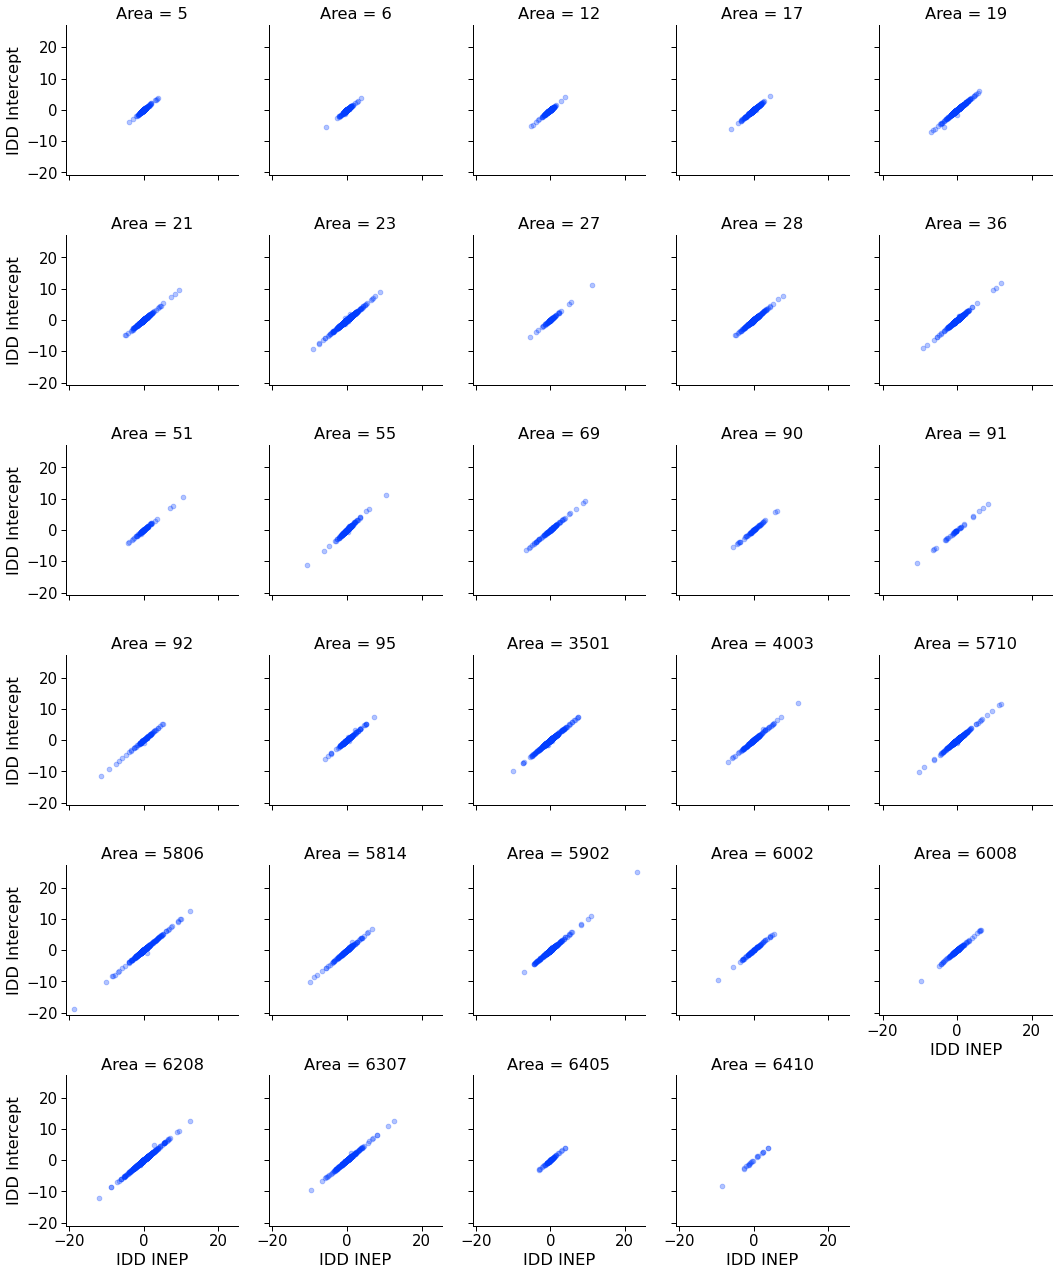

In [55]:
g = sns.FacetGrid(comps,col='Area',height=3,col_wrap=5)
g.map(plt.scatter,'IDD INEP','IDD Intercept',alpha=0.3);

## Diferent model specifications
Not used in paper

In [66]:
formula = 'nota ~ ch + cn + mt + lc + (1|adm/curso)'
model = Lmer(formula,data=md19.query("area == 5710"))
model.fit()

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: nota~ch+cn+mt+lc+(1|adm/curso)

Family: gaussian	 Inference: parametric

Number of observations: 38364	 Groups: {'curso:adm': 712.0, 'adm': 3.0}

Log-likelihood: -142040.365 	 AIC: 284080.730

Random effects:

                  Name     Var    Std
curso:adm  (Intercept)   9.519  3.085
adm        (Intercept)   6.037  2.457
Residual                95.671  9.781

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-20.950,-23.949,-17.951,1.530,2.640,-13.693,0.002,**
ch,0.036,0.034,0.038,0.001,37956.516,32.180,0.000,***
cn,0.028,0.026,0.030,0.001,38070.680,26.525,0.000,***
mt,0.034,0.032,0.035,0.001,38216.550,52.409,0.000,***
lc,0.012,0.010,0.014,0.001,37945.633,11.109,0.000,***


In [67]:
data[:3]

,ano,ies,catadm,orgacad,area,curso,municipio,tp_inscricao,ingresso,tp_pres,nota,anoenem,cn,ch,lc,mt,adm,anosgrad,enem,ncurso
0,2019,1,1,10028,5710,3,5103403,1,2014,555,49.5,2013,659.3,655.5,626.7,743.7,pub,5,671.300,50
1,2019,1,1,10028,5710,3,5103403,1,2015,555,52.6,2014,671.7,693.9,618.1,697.3,pub,4,670.250,50
2,2019,1,1,10028,5710,3,5103403,1,2013,555,52.1,2012,591.4,633.9,604.0,735.4,pub,6,641.175,50


In [68]:
model.summary()

Formula: nota~ch+cn+mt+lc+(1|adm/curso)

Family: gaussian	 Inference: parametric

Number of observations: 38364	 Groups: {'curso:adm': 712.0, 'adm': 3.0}

Log-likelihood: -142040.365 	 AIC: 284080.730

Random effects:

                  Name     Var    Std
curso:adm  (Intercept)   9.519  3.085
adm        (Intercept)   6.037  2.457
Residual                95.671  9.781

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),-20.950,-23.949,-17.951,1.530,2.640,-13.693,0.002,**
ch,0.036,0.034,0.038,0.001,37956.516,32.180,0.000,***
cn,0.028,0.026,0.030,0.001,38070.680,26.525,0.000,***
mt,0.034,0.032,0.035,0.001,38216.550,52.409,0.000,***
lc,0.012,0.010,0.014,0.001,37945.633,11.109,0.000,***
